#  Финальный проект. Предсказание температуры стали

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

In [2]:
r_state = 120922

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [3]:
df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv') 
df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv') 
df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv') 
df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')           
df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

## План работы

- исследовательский анализ данных;
- предобработка данных (обработка аномалий и выбросов, приведение данных к нужному типу); 
- подготовка данных (объединение таблиц, выделение главных показателей, расчёты);
- выбор и обучение модели, подбор параметров;
- тестирование модели, сравнение с константной моделью.

## Исследовательский анализ данных

### Данные об электродах

In [4]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [5]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
df_arc.isna().mean().sort_values(ascending=False)

key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64

In [7]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


<AxesSubplot:ylabel='Frequency'>

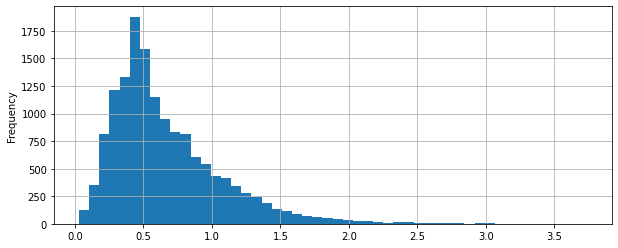

In [8]:
df_arc['Активная мощность'].plot(kind='hist', bins=(50), figsize=(10, 4), grid=True)

<AxesSubplot:ylabel='Frequency'>

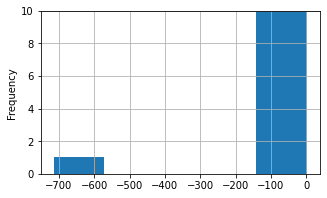

In [9]:
df_arc['Реактивная мощность'].plot(kind='hist', ylim=(0, 10), bins=(5), figsize=(5, 3), grid=True)

<AxesSubplot:ylabel='Frequency'>

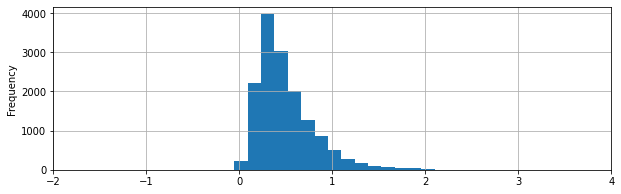

In [10]:
df_arc['Реактивная мощность'].plot(kind='hist', xlim=(-2, 4), bins=(5000), figsize=(10, 3), grid=True)

- датасет не содержит пропусков;
- столбцы со значениями начала и конца нагрева можно перевести в `datetime`;
- в столбце `Реактивная мощность` есть аномально низкие значения;

### Данные о подаче сыпучих материалов 

In [11]:
df_bulk.head(3)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


In [12]:
df_bulk_time.head(3)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40


In [13]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [14]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [15]:
df_bulk.isna().mean().sort_values(ascending=False)

Bulk 8     0.999680
Bulk 13    0.994247
Bulk 9     0.993928
Bulk 2     0.992969
Bulk 7     0.992010
Bulk 5     0.975391
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 1     0.919463
Bulk 6     0.815916
Bulk 4     0.675935
Bulk 3     0.585171
Bulk 15    0.281560
Bulk 12    0.217002
Bulk 14    0.103228
key        0.000000
dtype: float64

In [16]:
df_bulk_time.isna().mean().sort_values(ascending=False)

Bulk 8     0.999680
Bulk 13    0.994247
Bulk 9     0.993928
Bulk 2     0.992969
Bulk 7     0.992010
Bulk 5     0.975391
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 1     0.919463
Bulk 6     0.815916
Bulk 4     0.675935
Bulk 3     0.585171
Bulk 15    0.281560
Bulk 12    0.217002
Bulk 14    0.103228
key        0.000000
dtype: float64

In [17]:
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


- в таблице много пропущенных значений - заменим на 0;
- количество пропущенных значений в `df_bulk` и `df_bulk_time` одинаковое;
- столбцы со значениями времени можно перевести в `datetime`.

### Данные о продувке сплава газом

In [18]:
df_gas.head(3)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


In [19]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [20]:
df_gas.isna().mean().sort_values(ascending=False)

key      0.0
Газ 1    0.0
dtype: float64

In [21]:
df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<AxesSubplot:ylabel='Frequency'>

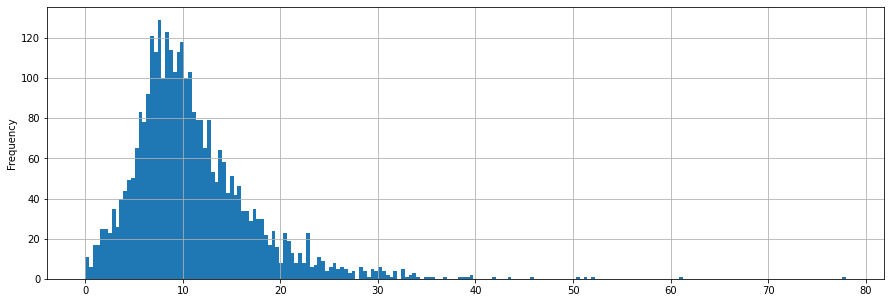

In [22]:
df_gas['Газ 1'].plot(kind='hist', bins=(200), figsize=(15, 5), grid=True)

- датасет не содержит пропусков;
- распределение близко к нормальному;
- возможно, есть небольшое количество выбросов.

### Результаты измерения температуры

In [23]:
df_temp.head(3)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0


In [24]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [25]:
df_temp.isna().mean().sort_values(ascending=False)

Температура     0.182373
key             0.000000
Время замера    0.000000
dtype: float64

In [26]:
df_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


<AxesSubplot:ylabel='Frequency'>

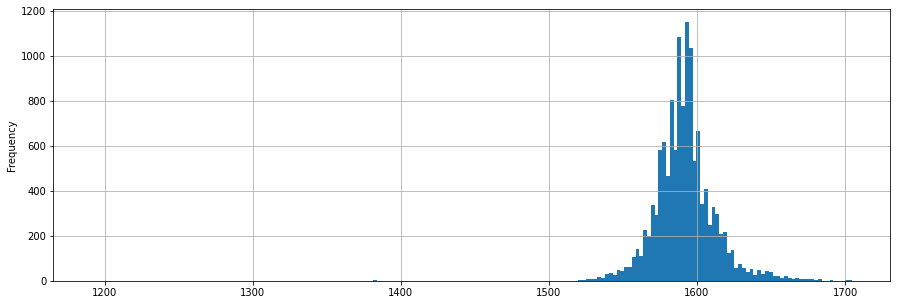

In [27]:
df_temp['Температура'].plot(kind='hist', bins=(200), figsize=(15, 5), grid=True)

- датасет содержит 18% пропусков в столбце с температурой;
- столбец со значением времени замера можно перевести в `datetime`.
- распределение близко к нормальному;
- возможно, есть небольшое количество выбросов (низкая температура).

### Данные о проволочных материалах

In [28]:
df_wire.head(3)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_wire_time.head(3)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [31]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [32]:
df_wire.isna().mean().sort_values(ascending=False)

Wire 5    0.999675
Wire 7    0.996430
Wire 4    0.995456
Wire 8    0.993833
Wire 9    0.990587
Wire 3    0.979552
Wire 6    0.976306
Wire 2    0.649789
Wire 1    0.008439
key       0.000000
dtype: float64

In [33]:
df_wire_time.isna().mean().sort_values(ascending=False)

Wire 5    0.999675
Wire 7    0.996430
Wire 4    0.995456
Wire 8    0.993833
Wire 9    0.990587
Wire 3    0.979552
Wire 6    0.976306
Wire 2    0.649789
Wire 1    0.008439
key       0.000000
dtype: float64

In [34]:
df_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<AxesSubplot:ylabel='Frequency'>

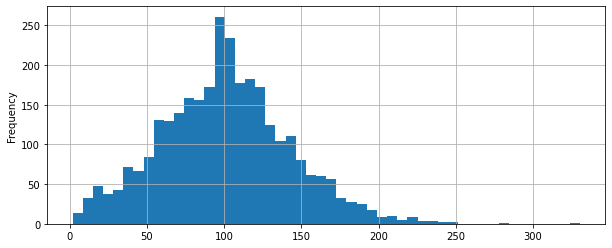

In [35]:
df_wire['Wire 1'].plot(kind='hist', bins=(50), figsize=(10, 4), grid=True)

- в таблице много пропущенных значений - заменим на 0;
- количество пропущенных значений в `df_wire` и `df_wire_time` одинаковое;
- распределение в столбце `Wire 1` (с минимальным кол-вом пропусков) близко к нормальному;
- столбцы со значениями времени можно перевести в `datetime`.

## Предобработка данных

Приведем столбцы со значениями времени к соответствующему типу данных:

In [36]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

In [37]:
df_arc.head(3)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805


In [38]:
df_temp.head(3)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0


Заполним пропуски нулями, т.к. пропуск означает отсутствие добавок

In [39]:
df_wire = df_wire.fillna(0)
df_bulk = df_bulk.fillna(0)

Удалим аномально низкие значения в `df_temp`, которые ниже минимальной температуры плавления стали - 1450 Цельсия

In [40]:
df_temp = df_temp.drop(df_temp[df_temp['Температура'] < 1450].index)

In [41]:
df_temp.describe()

,key,Температура
count,15900.000000,12999.000000
mean,1607.837233,1592.020078
std,942.356124,19.853665
min,1.000000,1519.000000
25%,789.750000,1581.000000
50%,1617.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Удалим пропуски:

In [42]:
df_temp = df_temp.dropna().reset_index(drop=True)

Удалим аномально низкое значение мощности:

In [43]:
df_arc[df_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [44]:
df_arc[df_arc['key'] == 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


In [45]:
df_arc = df_arc.drop(df_arc[df_arc['key'] == 2116].index)

In [46]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14872.000000,14872.000000,14872.000000
mean,1615.085732,0.670497,0.500763
std,934.661090,0.408195,0.310897
min,1.000000,0.030002,0.020806
25%,806.000000,0.395297,0.291008
50%,1616.000000,0.555588,0.416280
75%,2429.000000,0.857121,0.637476
max,3241.000000,3.731596,2.676388


Выводы:

- преобразовали столбцы со значениями времени в `df_temp` и `df_arc`;
- заполнили пропуски в `df_wire` и `df_bulk`;
- удалили аномально низкие значения в `df_temp` и `df_arc`.

## Подготовка данных 

### Данные изменения температуры 

Подготовим таблицу с данными изменениями температуры:

In [47]:
df_temp.head(3)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0


Создадим датафреймы с первым и последним замером температуры с группировкой по ключу:

In [48]:
temp_first = df_temp.groupby('key').first().reset_index()
temp_last = df_temp.groupby('key').last().reset_index()

In [49]:
temp_first.head(3)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0


In [50]:
temp_last.head(3)

,key,Время замера,Температура
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0


Избавимся от строк, где начальное время замера равно конечному:

In [51]:
t_fst = (temp_first[temp_first['Время замера'] == temp_last['Время замера']]).index

In [52]:
t_lst = (temp_last[temp_last['Время замера'] == temp_first['Время замера']]).index

In [53]:
temp_first = temp_first.drop(temp_first.index[t_fst]).reset_index(drop=True)
temp_last = temp_last.drop(temp_last.index[t_lst]).reset_index(drop=True)

In [54]:
temp_first.shape

(2475, 3)

In [55]:
temp_last.shape

(2475, 3)

In [56]:
temp_first = temp_first.rename(columns={'Температура':'Начальная_температура'})
temp_last = temp_last.rename(columns={'Температура':'Конечная_температура'})

In [57]:
temp_first = temp_first.drop(['Время замера'], axis=1)
temp_last = temp_last.drop(['Время замера'], axis=1)

In [58]:
temp_first.head(3)

,key,Начальная_температура
0,1,1571.0
1,2,1581.0
2,3,1596.0


In [59]:
temp_last.head(3)

,key,Конечная_температура
0,1,1613.0
1,2,1602.0
2,3,1599.0


Объединим данные используя параметр `inner`, чтобы в итоговой таблице были данные без пропусков:

In [60]:
df_temp_full = temp_first.merge(temp_last, on=['key'], how='inner')
df_temp_full.shape

(2475, 3)

In [61]:
df_temp_full.head(3)

,key,Начальная_температура,Конечная_температура
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0


### Данные об электродах.

In [62]:
df_arc.head(3)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805


Создадим датафреймы с первым и последним замером нагрева дуги с группировкой по ключу:

In [63]:
arc_first = df_arc.groupby('key').first().reset_index()
arc_last = df_arc.groupby('key').last().reset_index()

In [64]:
arc_first.head(3)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
2,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [65]:
arc_last.head(3)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
1,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
2,3,2019-05-03 12:31:14,2019-05-03 12:32:19,0.250280,0.155901


Избавимся от строк, где  где начальное время нагрева равно конечному:

In [66]:
arc_first.shape

(3213, 5)

In [67]:
len(arc_first[(arc_first['Начало нагрева дугой'] == arc_last['Начало нагрева дугой']) & 
          (arc_first['Конец нагрева дугой'] == arc_last['Конец нагрева дугой'])])

39

In [68]:
len(arc_last[(arc_first['Начало нагрева дугой'] == arc_last['Начало нагрева дугой']) & 
          (arc_first['Конец нагрева дугой'] == arc_last['Конец нагрева дугой'])])

39

In [69]:
diff_fst = (arc_first[(arc_first['Начало нагрева дугой'] == arc_last['Начало нагрева дугой']) &           
                      (arc_first['Конец нагрева дугой'] == arc_last['Конец нагрева дугой'])]).index

In [70]:
diff_lst = (arc_last[(arc_first['Начало нагрева дугой'] == arc_last['Начало нагрева дугой']) & 
                    (arc_first['Конец нагрева дугой'] == arc_last['Конец нагрева дугой'])]).index

In [71]:
arc_first = arc_first.drop(arc_first.index[diff_fst]).reset_index(drop=True)
arc_last = arc_last.drop(arc_last.index[diff_lst]).reset_index(drop=True)

In [72]:
arc_first.shape

(3174, 5)

In [73]:
arc_last.shape

(3174, 5)

In [74]:
arc_first = arc_first.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1)
arc_last = arc_last.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1)

In [75]:
arc_first = arc_first.rename(columns={'Активная мощность':'Начальная_активная_мощность', 'Реактивная мощность':'Начальная_реактивная_мощность'})
arc_last = arc_last.rename(columns={'Активная мощность':'Конечная_активная_мощность', 'Реактивная мощность':'Конечная_реактивная_мощность'})

In [76]:
arc_first.head(3)

,key,Начальная_активная_мощность,Начальная_реактивная_мощность
0,1,0.976059,0.687084
1,2,0.438063,0.283043
2,3,1.062053,0.671494


In [77]:
arc_last.head(3)

,key,Конечная_активная_мощность,Конечная_реактивная_мощность
0,1,0.692755,0.414397
1,2,0.827743,0.516874
2,3,0.250280,0.155901


Расчитаем полную мощность:

In [78]:
def full_p(row):
    p = (row['Активная мощность']**2 + row['Реактивная мощность']**2)**0.5
    return p

In [79]:
fp_arc = df_arc.groupby('key').median().reset_index()

In [80]:
fp_arc['Полная_мощность'] = fp_arc.apply(full_p, axis=1)

In [81]:
fp_arc = fp_arc.drop(['Активная мощность', 'Реактивная мощность'], axis=1)
fp_arc.head(3)

,key,Полная_мощность
0,1,0.959010
1,2,0.776753
2,3,0.508140


Вычислим время нагрева электродов:

In [82]:
df_arc['Время_нагрева'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']) / np.timedelta64(1, 's')
df_arc.head(3)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время_нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0


In [83]:
arc_time = df_arc.groupby('key').agg({'Время_нагрева':['count', 'sum']}).reset_index()
arc_time.columns = ['key', 'Количество_циклов', 'Время_нагрева']
arc_time.head(3)

,key,Количество_циклов,Время_нагрева
0,1,5,1098.0
1,2,4,811.0
2,3,5,655.0


In [84]:
fp_arc = arc_time.merge(fp_arc, on='key', how='inner')
fp_arc.head(3)

,key,Количество_циклов,Время_нагрева,Полная_мощность
0,1,5,1098.0,0.959010
1,2,4,811.0,0.776753
2,3,5,655.0,0.508140


Вычислим работу:

In [85]:
fp_arc['Работа'] = fp_arc['Время_нагрева'] * fp_arc['Полная_мощность']
fp_arc.head(3)

,key,Количество_циклов,Время_нагрева,Полная_мощность,Работа
0,1,5,1098.0,0.959010,1052.992595
1,2,4,811.0,0.776753,629.946311
2,3,5,655.0,0.508140,332.831978


In [86]:
fp_arc.shape

(3213, 5)

In [87]:
arc_last.shape

(3174, 3)

In [88]:
arc_first.shape

(3174, 3)

Объединим таблицы:

In [89]:
df_arc_full = arc_first.merge(arc_last, on='key', how='inner')
df_arc_full.head(3)

,key,Начальная_активная_мощность,Начальная_реактивная_мощность,Конечная_активная_мощность,Конечная_реактивная_мощность
0,1,0.976059,0.687084,0.692755,0.414397
1,2,0.438063,0.283043,0.827743,0.516874
2,3,1.062053,0.671494,0.250280,0.155901


In [90]:
df_arc_full = df_arc_full.merge(fp_arc, on='key', how='inner')
df_arc_full.head(3)

,key,Начальная_активная_мощность,Начальная_реактивная_мощность,Конечная_активная_мощность,Конечная_реактивная_мощность,Количество_циклов,Время_нагрева,Полная_мощность,Работа
0,1,0.976059,0.687084,0.692755,0.414397,5,1098.0,0.959010,1052.992595
1,2,0.438063,0.283043,0.827743,0.516874,4,811.0,0.776753,629.946311
2,3,1.062053,0.671494,0.250280,0.155901,5,655.0,0.508140,332.831978


### Объединенный датасет

In [91]:
df_full = df_arc_full.merge(df_temp_full, on='key', how='inner')
df_full.shape

(2442, 11)

In [92]:
df_full = df_full.merge(df_gas, on='key', how='inner')
df_full.shape

(2440, 12)

In [93]:
df_full = df_full.merge(df_wire, on='key', how='inner')
df_full.shape

(2338, 21)

In [94]:
df_full = df_full.merge(df_bulk, on='key', how='inner')
df_full.shape

(2303, 36)

In [95]:
df_full.head(3)

,key,Начальная_активная_мощность,Начальная_реактивная_мощность,Конечная_активная_мощность,Конечная_реактивная_мощность,Количество_циклов,Время_нагрева,Полная_мощность,Работа,Начальная_температура,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.976059,0.687084,0.692755,0.414397,5,1098.0,0.959010,1052.992595,1571.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.438063,0.283043,0.827743,0.516874,4,811.0,0.776753,629.946311,1581.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,1.062053,0.671494,0.250280,0.155901,5,655.0,0.508140,332.831978,1596.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0


In [96]:
df_full.duplicated().sum()

0

Выводы:

- создали датафрейм с начальной и конечной температурами;
- по данным об электродах рассчитали полную мощность, количество циклов, время нагрева и работу;
- объединили данные в общий датафрейм.

## Анализ моделей

### Подготовка признаков

In [97]:
features = df_full.drop(['Конечная_температура', 'key'], axis=1)
target = df_full['Конечная_температура']

In [98]:
features.head(3)

,Начальная_активная_мощность,Начальная_реактивная_мощность,Конечная_активная_мощность,Конечная_реактивная_мощность,Количество_циклов,Время_нагрева,Полная_мощность,Работа,Начальная_температура,Газ 1,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,0.976059,0.687084,0.692755,0.414397,5,1098.0,0.959010,1052.992595,1571.0,29.749986,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,0.438063,0.283043,0.827743,0.516874,4,811.0,0.776753,629.946311,1581.0,12.555561,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,1.062053,0.671494,0.250280,0.155901,5,655.0,0.508140,332.831978,1596.0,28.554793,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0


In [99]:
target.head(3)

0    1613.0
1    1602.0
2    1599.0
Name: Конечная_температура, dtype: float64

Разделим выборки в соотношении 3 к 1:

In [100]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=r_state)

In [101]:
features_train.head(3)

,Начальная_активная_мощность,Начальная_реактивная_мощность,Конечная_активная_мощность,Конечная_реактивная_мощность,Количество_циклов,Время_нагрева,Полная_мощность,Работа,Начальная_температура,Газ 1,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
790,0.470265,0.342909,0.278104,0.189851,7,969.0,0.606882,588.068999,1575.0,11.616807,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,117.0,104.0
2072,0.443274,0.329236,0.924192,0.859182,2,510.0,0.905856,461.986603,1598.0,18.190581,...,0.0,0.0,0.0,0.0,0.0,0.0,513.0,0.0,194.0,0.0
2128,0.505565,0.498651,0.362735,0.366029,3,506.0,0.710105,359.313021,1620.0,7.340110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Выводы:

- разделили данные на обучающие признаки и целевой признак;
- создали обучающие и тестовые выборки.

Масштабирование признаков не производим, т.к. оно сильно ухудшало качество на тестовой выборке.

### Выбор модели

Обучим разные модели и подберем гиперпараметры:

### Модель Случайный лес

In [102]:
rfr = RandomForestRegressor(random_state=r_state)

parametrs = {'n_estimators': range (150, 301, 100),
              'max_depth': range (20, 41, 10)}

In [103]:
%%time

grid = GridSearchCV(rfr, parametrs, cv=3, scoring='neg_mean_absolute_error')
grid.fit(features_train, target_train)

grid.best_params_

CPU times: user 41.8 s, sys: 74.3 ms, total: 41.8 s
Wall time: 42.1 s


{'max_depth': 30, 'n_estimators': 250}

In [104]:
print(f'MAE: {(grid.best_score_ * -1):.3f}')

MAE: 6.237


### Модель LightGBM

In [105]:
lgr = LGBMRegressor(random_state=r_state)

parametrs = {'n_estimators': range (10, 221, 100),
              'max_depth': range (10, 41, 10),
              'num_leaves': range (10, 31, 10)}

In [106]:
%%time

grid = GridSearchCV(lgr, parametrs, cv=3, scoring='neg_mean_absolute_error')
grid.fit(features_train, target_train)

grid.best_params_

CPU times: user 1min 35s, sys: 814 ms, total: 1min 36s
Wall time: 1min 36s


{'max_depth': 10, 'n_estimators': 110, 'num_leaves': 10}

In [107]:
print(f'MAE: {(grid.best_score_ * -1):.3f}')

MAE: 6.250


Выводы:

- подобрали гиперпараметры для моделей RandomForest и LightGBM
  - для модели RandomForestRegressor MAE равен 6.24
  - для модели LGBMRegressor MAE равен 6.25

Выбираем модель с наилучшим результатом - RandomForestRegressor.

## Тестирование модели

In [108]:
model = RandomForestRegressor(max_depth=30, n_estimators=250, random_state=r_state) 

In [109]:
model.fit(features_train, target_train)
predictions = model.predict(features_test)

In [110]:
print(f'MAE: {mean_absolute_error(target_test, predictions):.3f}')

MAE: 6.106


<AxesSubplot:title={'center':'Сравнение предсказаний модели с правильными ответами'}, ylabel='Frequency'>

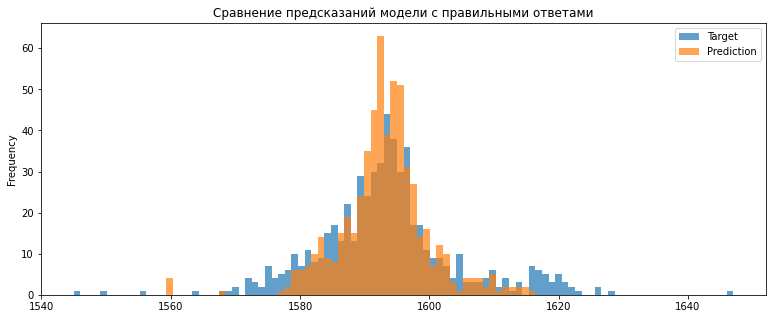

In [111]:
pd.DataFrame({'Target': target_test, 'Prediction': predictions}).plot(
    kind='hist',
    figsize=(13, 5), 
    title='Сравнение предсказаний модели с правильными ответами', 
    bins=100, 
    alpha=0.7)

На тестовых данных метрика МАЕ получилась равной 6.1, что является хорошим результатом. По графику можем заметить, что предсказания модели достаточно точно угадывают значения целевого признака - конечной температуры стали.

### Сравнение с константной моделью

Проверим модель на адекватность с помощью Dummy модели:

In [112]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(features_train, target_train)

dummy_pred = dummy_regr.predict(features_test)

In [113]:
mean_absolute_error(dummy_pred, target_test)

7.829861111111111

DummyRegressor показал метрику МАЕ хуже, чем модель RandomForestRegressor, следовательно модель проверку на адекватность прошла.

## Отчет

Проект выполнен в соответствии с планом:

- Был проведен исследовательский анализ данных, после которого проводилась предобработка, включающая в себя заполнение и удаление пропусков, приведение данных к соответствующему типу, удаление аномальных значений. 
- Далее мы подготавливали данные – выделяли признаки в зависимости от значения времени, выполняли расчет новых признаков: полная мощность, затраченное время, работа и количество циклов.
- Используемые признаки: 
  - `Начальная активная мощность` - первое значение по ключу; 
  - `Начальная реактивная мощность` - был удален ключ с аномально низким значением мощности; 
  - `Конечная активная мощность` - последнее значение по ключу;
  - `Конечная реактивная мощность` - был удален ключ с аномально низким значением мощности;
  - `Полная мощность` - рассчитана как корень из суммы квадратов активной и реактивной мощностей; 
  - `Время нагрева` (секунды) - разница между концом и началом времени нагрева дугой; 
  - `Работа` - рассчитана по формуле: Время х Полная мощность;
  - `Количество циклов` - вычислено с помощью агрегирующей функции count во время группировки по ключу;
  - `Начальная температура` - на этапе предобработки были удалены значения температуры ниже 1450 градусов Цельсия и удалены пропуски; 
  - `Газ 1` (данные о продувке сплава газом) - без изменений; 
  - `Wire 1-9` (данные объема проволочных материалов) - во время предобработки пропущенные значения были заполнены нулями;   
  - `Bulk 1-15` (данные объема сыпучих материалов) - пропущенные значения также были заполнены нулями.
- Целевой признак - `Конечная температура`.
- После создания тренировочных и тестовых выборок выполнялся выбор модели между RandomForest и LightGBM. С помощью GridSearch мы провели подбор гиперпараметров и определили модель с наилучшим качеством - **RandomForestRegressor**, которая показала значение **МАЕ = 6,24** на тренировочной выборке. 
- Параметры модели: **max_depth=30, n_estimators=250, random_state=120922.**
- На тестовой выборке модель показала также хорошую метрику **МАЕ** равную **6,1**. 
- Для проверки модели на константных признаках мы использовали DammyRegressor, итоговая метрика которого была равна **7,83**, следовательно, проверку на адекватность наша модель прошла.

В процессе выполнения проекта были сложности, связанные с пониманием технологического процесса и анализом большого количества информации, что несколько замедляло процесс. Также достаточно много времени уходило на подбор гиперпараметров.